## 1-D Transiet heat diffusion solver with Physics Informed Neural Networks 

**Import the libraries**

In [3]:
## Import basic numerical and plotting packages ##
from utils.importer import *

## Import the numerical PDE solver ##
from utils.numericalSolver import NumPDE

# ## Import the neural network dataprocessor and framework ##
# from utils.dataNN import DataPreprocessor, DataBasedNN

**Setup the calculation details**

The governing equation is by, 

$$\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}$$  

The domain and time range is defined as follows, 

$$\forall \, x \in (0,l) \text{ and } 0 < t < t_{range}$$

Initial conditions are as follows,

$$T(x, 0) = 0 $$

Boundary conditions are defined as,

$$ \left.\frac{\partial T}{\partial x}\right\vert_{(0,t)} = 0 \text{ and } \left. T \right\vert_{(l,t)} = sin(t)$$

In [13]:
## total time of simulation and length of the system ##
trange, l = 2*np.pi, 1

## Package the time and spatial domain ##
extent = [[0, l], [0, trange]]

## Specify time and space discretizations ##
nx, nt = 16, 10

## Specify the test train split based on time ##
split = 0.7

## Specify how much of available training data will be randomly picked for training in the domain, IC and BCs##
frac = 0.8

## Specify the number of random points in the domain
N_domain = 100

## Neural Network structure ##
    ## Two inputs (x and t) and one output (temperature)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

## Initialize the 1-D grid for the numerical solver ##
grid = CartesianGrid([[0, l]], nx)  

## Setup the initial condition of the system ##
    ## For the current problem it is set at 0 ##
field = ScalarField(grid, 0)        

## Definition of the diffusion PDE ##
    ## Specify diffusivity of the domain ##
diffusivity = 0.1
    ## Define the rhs of differential equation ##
rhs = f"(({diffusivity}) * laplace(c))"
    ## Specify the boundary conditions, first left end and then right end ##
bc = [[{'derivative':0}, {'value_expression':'sin(t)'}]]
    ## package thegoverning equation and boundary conditions ##
eq = PDE({"c": f"{rhs}"}, bc=bc)

**Obtain the numerical solution**

In [14]:
## Obtain the numerical solution ##
    ## We use explicit RK-4 adaptive time stepping ##
    ## Also specified the time discretization  using the variable nt ##
if os.path.isfile('saved/numSol.pkl'):
    with open('saved/numSol.pkl', 'rb') as file:
        numSol = pkl.load(file)
else:
    numSol = NumPDE(eq, grid, field, 'Explicit', trange, trange/nt).ground_truth

**Create the NN data from numerical solution**

In [20]:
from utils.importer import *


class DataPreprocessor():

    def __init__(self, 
                 sol: dict,
                 split: float,
                 frac: float,
                 extent: np.ndarray,
                 N_f: int):

        ## Store the domain dimensions
        self.extent = extent

        ## Dictionary to store data
        self.sol = sol
        
        ## Generate ground truth
        self.create_ground_truth()

        ## Split the dataset into test and train
        self.test_train_split(split)

        ## Randomly pick data points out of the train datasets ##
        self.traindata = {}
        self.create_train_dataset(frac, N_f)
#         self.create_dataset('test', frac)
# #         self.ax.legend(bbox_to_anchor=(0.5, 1.1), ncol=2, loc='upper center')

        ## Show the plot and svae the figure
        plt.show()
        self.fig.savefig('results/groundtruth.png')
        
    ## Function to create dataset out of provided grid and function values
    def create_train_dataset(self, frac, N_f):
        
        ## Extract the exact solution ##
        data = self.rawdata['train']
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])
        
        ## Specify the number of points for boundaries ##
        N_ic = int(x.shape[0]*frac)
        N_bc = int(t.shape[0]*frac)
        N_d = int(u[1:,1:-1].shape[0]*frac)*int(u[1:,1:-1].shape[1]*frac)
        
        ## Create grid ##
        X, T = np.meshgrid(x,t)
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]     
        
        ## Start picking random points ##
            ## from initial condition
        train_ic = {}
        inp_ic = np.hstack((X[:1,:].T, T[:1,:].T))
        out_ic = u[:1,:].T
        idx_ic = np.random.choice(inp_ic.shape[0], N_ic, replace=False)
        train_ic.update({'inp': inp_ic[idx_ic, :], 
                         'out': out_ic[idx_ic, :]})
            ## from left boundary condition
        train_bcl = {}
        inp_bcl = np.hstack((X[:,:1], T[:,:1]))
        out_bcl = u[:,:1]
        idx_bcl = np.random.choice(inp_bcl.shape[0], N_bc, replace=False)
        train_bcl.update({'inp': inp_bcl[idx_bcl, :], 
                          'out': out_bcl[idx_bcl, :]})
            ## from right boundary condition
        train_bcr = {}
        inp_bcr = np.hstack((X[:,-1:], T[:,-1:]))
        out_bcr = u[:,-1:]
        idx_bcr = np.random.choice(inp_bcr.shape[0], N_bc, replace=False)
        train_bcr.update({'inp': inp_bcr[idx_bcr, :], 
                          'out': out_bcr[idx_bcr, :]})
            ## from the domain
        train_dom = {}
        inp_dom = np.hstack((X[1:,1:-1].flatten()[:, None],
                             T[1:,1:-1].flatten()[:, None]))
        out_dom = u[1:,1:-1].flatten()[:,None]
        idx_dom = np.random.choice(inp_dom.shape[0], N_d, replace=False)
        train_dom.update({'inp': inp_dom[idx_dom, :], 
                          'out': out_dom[idx_dom, :]})
            ## from the PDE
        train_pde = {}
        lb = inp.min(0)
        ub = inp.max(0) 
        inp_pde = lb + (ub-lb)*lhs(2, N_f)
        train_pde.update({'inp': inp_pde})
            ## Package all the dictionaries into traindata
        self.traindata.update({'ic': train_ic, 'bcl': train_bcl, 
                               'bcr': train_bcr, 'dom': train_dom,
                               'pde': train_pde})
        
    ## Function to split the incoming dataset into test and train based on time
    def test_train_split(self, split):

        ## Define the index to split the dataset        
        nt = self.sol['t'].shape[0]
        idx_split = int(nt*split)

        ## store the test and train splits into dictionaries
        test = {}
        train = {}

        ## store time in test and train
        train['t'] = self.sol['t'][:idx_split]
        test['t'] = self.sol['t'][idx_split:]

        ## store time in test and train
        nx = self.sol['x'].shape[0]
        train['x'] = self.sol['x']
        test['x'] = self.sol['x']

        ## store solution in test and train
        train['u'] = self.sol['u'][:idx_split,:]
        test['u'] = self.sol['u'][idx_split:,:]

        ## Store the final splits into dictionary
        self.rawdata = {'train': train,
                        'test' : test}
        
        ## Plot the test train partition
        t_split = self.sol['t'][idx_split]
        x_test = self.sol['x'][int(0.4*nx)]
        x_train = self.sol['x'][int(0.6*nx)]
        self.ax.plot(self.sol['x'], t_split*np.ones((nx,1)), 'g--')
        self.ax.arrow(x_test, t_split, 0, 0.5, width=0.02, facecolor='r', alpha=1)
        self.ax.arrow(x_train, t_split, 0, -0.5, width=0.02, facecolor='k', alpha=1)
        self.ax.annotate('Test', xy=(x_test-0.05, t_split+0.7), fontsize=12, color = 'r')
        self.ax.annotate('Train', xy=(x_train-0.05, t_split-0.8), fontsize=12, color = 'k')


    ## Function to create the ground truth over the domain from the numerical solver data
    def create_ground_truth(self):

        ## Exctract the data
        t = self.sol['t'].flatten()[:,None]
        x = self.sol['x'].flatten()[:,None]
        u = np.real(self.sol['u'])

        ## Create grid
        X, T = np.meshgrid(x,t)

        ## Compile the flattened grid and function values
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]

        ## Store the data
        self.ground_truth = {'input': inp,
                             'output': out}
        
        ## Plot the ground truth
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(self.sol['u'], origin='lower', aspect='auto',
                       extent=np.asarray(self.extent).flatten(),
                       interpolation='bilinear', cmap='rainbow')
        fig.colorbar(im, ax=ax, location='right')

        ## Save the figure object
        self.ax = ax
        self.fig = fig

    


    ## Function to create dataset out of provided grid and function values
    def create_dataset(self, which, frac):

        if which == 'train':
            data = self.rawdata['train']
            color='k'
        else:
            data = self.rawdata['test']
            color='r'
        ## Exctract the data
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])

        ## Create grid
        X, T = np.meshgrid(x,t)

        ## Compile the flattened grid and function values
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]

        ## Collect datapoints on the boundaries
            ## initial condition
        if which == 'train':
            inp_ic = np.hstack((X[:1,:].T, T[:1,:].T))
            out_ic = u[:1,:].T
        else:
            inp_ic = np.empty((0,2))
            out_ic = np.empty((0,1))
            ## boundary condition on left side of the domain
        inp_bcl = np.hstack((X[:,:1], T[:,:1]))
        out_bcl = u[:,:1]
            ## boundary condition on right side of the domain
        inp_bcr = np.hstack((X[:,-1:], T[:,-1:]))
        out_bcr = u[:,-1:]
            ## Append all the boundary data with the function value
        inp_all_bdr = np.vstack([inp_ic, inp_bcl, inp_bcr])
        out_all_bdr = np.vstack([out_ic, out_bcl, out_bcr])
            ## randomly pick points on the boundaries
        idx_bdr = np.random.choice(out_all_bdr.shape[0],
                                   int(frac*out_all_bdr.shape[0]),
                                   replace=False)
        inp_bdr = inp_all_bdr[idx_bdr, :]
        out_bdr = out_all_bdr[idx_bdr, :]
            ## Show the boundary points
#         self.ax.scatter(inp_bdr[:,0], inp_bdr[:,1], marker='x',
#                         c = color, s=15, clip_on=False, alpha=0.8,
#                         linewidth=1, label=which)

        ## Collect datapoint in the domain
        if which == 'train':
            inp_all_dom = np.hstack((X[1:,1:-1].flatten()[:, None],
                                     T[1:,1:-1].flatten()[:, None]))
            out_all_dom = u[1:,1:-1].flatten()[:,None]
        else:
            inp_all_dom = np.hstack((X[:,1:-1].flatten()[:, None],
                                     T[:,1:-1].flatten()[:, None]))
            out_all_dom = u[:,1:-1].flatten()[:,None]

            ## randomly pick points on the domain
        idx_dom = np.random.choice(out_all_dom.shape[0],
                                   int(frac*out_all_dom.shape[0]),
                                   replace=False)
        inp_dom = inp_all_dom[idx_dom, :]
        out_dom = out_all_dom[idx_dom, :]
            ## Show the domain points
        # self.ax.scatter(inp_dom[:,0], inp_dom[:,1], marker='o',
        #                 edgecolors=color, facecolors='none', s=15,
        #                 clip_on=False)

        ## Store the dataset
        self.data[which] = {'input': np.vstack((inp_bdr, inp_dom)),
                            'output': np.vstack((out_bdr, out_dom))}

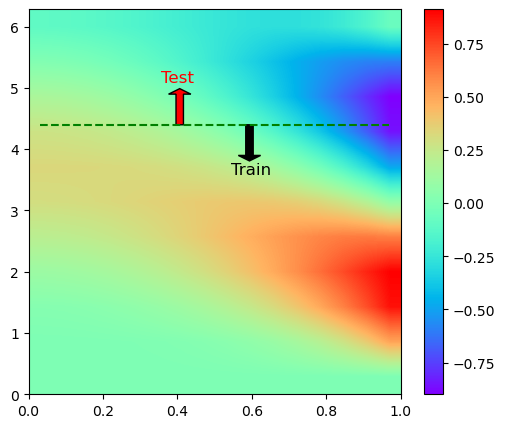

In [21]:
## Prepare the dataset for training
NNdata = DataPreprocessor(numSol, split, frac, extent, N_domain)

**Setup the NN, train and save the weights**

In [ ]:
model = DataBasedNN(NNdata.data, layers)

if os.path.isfile('saved/trained_parameters'):
    model.dnn.load_state_dict(torch.load('saved/trained_parameters', map_location=torch.device('cpu')))
else:
    model.train()
    torch.save(model.dnn.state_dict(), 'saved/trained_parameters')

**Run the predictions**

In [ ]:
model.predict(NNdata, [0, 0.25, 0.50, 0.75, 0.999], split, extent)